# Busqueda del Centro de Masa de la Densidad de Fuentes de Corriente

Primero, vamos a intentarlo con un experimento que tenga una actividad notoria. Aquí cargamos un archivo que contiene los datos de un experimento con actividad epiléptica. La región CA aparece muy activa varias veces en las mediciones del potencial de campo local, LFP de ahora en adelante.

In [2]:
muacamuaca=open("DatosActividadEpilepticaSelectos.bin", "r")
formaarray=(64,64,9101)
Datos=read(muacamuaca, Float64, formaarray)
tmax=formaarray[3]
close(muacamuaca)

In [4]:
tmax

9101

No todos los datos son interesentas. La actividad se concentra en los siguientes cuadros.

In [5]:
#Busquemos de momento aquellos adecuados para la platica en Heidelberg
Datos=Datos[:,:,1500:9100]
tmax=size(Datos)[3]
formaarray=(64,64,tmax)

(64,64,7601)

Aquí abajo definimos los filtros que matarán señales saturadas y pondran toda señal debajo de cierto umbral en cero.

In [6]:
function umbral(x)
    result=((abs(x)>500) ? 0 : x)
end;

function aplastar(x)
    result=((abs(x)<60) ? 0 : x)
end;

function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

UnNormGauss (generic function with 1 method)

La umbralización de Otsu la vamos a aplicar sobre la desviación estándar en la señal de cada electródo. Para ello, primero quitamos los canales saturados y después calculamos este valor.

In [7]:
#map!(umbral, Datos); #map! quiere decir map in situ
DesviacionPorElectrodo=zeros(64,64)
for j=1:64, k=1:64
    DesviacionPorElectrodo[j,k]=std(reshape(Datos[j,k,:],tmax));
end

Esta función calcula la desviación estándar por ventanas temporales en cada canal. Franco uso esta información para separar sus canales de actividad neuronal de aquellas de ruido por medio de un procedimiento relativamente complejo. Esto se puede simplificar usando el criterio de Otsu para separar en cada ventana temporal y obtener un *"criterio de Otsu por ventanas"*.

In [8]:
function SigmaVentanas(Datos, ancho, paso)
    anchomedio=floor(ancho/2)
    tantos=convert(Int, floor((length(Datos)-ancho)/paso))
    result=zeros(tantos)
    for t=1:tantos
        result[t]=std(Datos[(t-1)*paso+1:(t-1)*paso+ancho])
    end
    return result  
end

SigmaVentanas (generic function with 1 method)

Aquí implementamos el método de Otsu, tal cual.

In [9]:
function OtsuMethod(Data)
    #Pa que esto funcione hay que mandar los datos ya sin NaNs u otras mugres   
    binsdefault=2*ceil(Int,sqrt(length(Data)))
    (rango, cuentas)=hist(Data,binsdefault)
    tantos=length(rango)
    valores
    omega1=0
    omega2=0
    mu1=0
    mu2=0
    sigmab=0
    sigmabtemp=0
    tbest=0
    varlim=0
    for t=1:tantos-1
        omega1=sum(cuentas[1:t])
        omega2=sum(cuentas[t+1:tantos-1])
        mu1=sum(cuentas[1:t].*rango[1:t])/omega1
        mu2=sum(cuentas[t+1:tantos-1].*rango[t+1:tantos-1])/omega2        
        sigmabtemp=omega1*omega2*((mu1-mu2)^2)
        if sigmabtemp>sigmab
            sigmab=sigmabtemp
            tbest=t
            varlim=rango[t]
        end
    end
    return (sigmab,tbest,varlim)
end

function OtsuUmbralizar(DatosMatriz)
    # aplanar datos
    DataFlatten=reshape(DatosMatriz, size(DatosMatriz)[1]*size(DatosMatriz)[2])
    mascara=zeros(DatosMatriz)
    umbral=OtsuMethod(DataFlatten)[3]
    mascara=map(x->(x>umbral)?1:0, DatosMatriz)
    return mascara
end


OtsuUmbralizar (generic function with 1 method)

Aplicamos la función DesviacionPorVentana a ventanas de 350 cuadros de duración, y avanzando 35 cuadros cada vez. Esto corresponde a aproximadamente ventanas de $49.8 \mu s$ y pasos de $ 4.9 \mu s$.

In [10]:
ancho=350
paso=35
cuantasventanas=convert(Int, floor((tmax-ancho)/paso))
DesviacionPorVentana=zeros((64,64,cuantasventanas))
for j=1:64, k=1:64
    chorizo=reshape(Datos[j,k,:],tmax)
    DesviacionPorVentana[j,k,:]=SigmaVentanas(chorizo, ancho, paso)
end

Aqui es donde mezclamos el criterio de Franco con la umbralización de Otsu. A cada una de las ventanas de desviaciones calculadas anteriormente en el arreglo DesviacionPorVentana le aplicamos el umbral de Otsu. Con eso formamos una máscara donde vamos sumando puntos cada vez que un canal está dentro de la umbralización de Otsu.

In [11]:
SumaVentanasOtsuUmbral=zeros(64,64)
for t=1:cuantasventanas
    SumaVentanasOtsuUmbral+=OtsuUmbralizar(DesviacionPorVentana[:,:,t])
end

In [12]:
using PyPlot

INFO: Loading help data...


Usemos PyPlot para hacer un par de imagenes bonitas para poder seguir más fácilmente la discución. Lo que podremos llamar "densidad del umbral de Otsu" se puede ver en la siguiente figura.

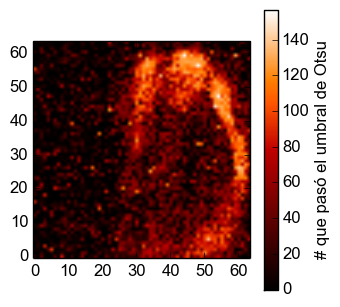

In [13]:
figure(figsize=(3.5,3.5))
imagen=imshow(SumaVentanasOtsuUmbral, cmap="gist_heat", origin="lower")
cbx=colorbar(imagen) 
cbx[:set_label]("# que pasó el umbral de Otsu")
#origin lower sigue la convención gnuplot. Origen abajo izquierda. 
#La otra sigue la convención matrix (default).

Como podemos ver, la umbralización de Otsu se acumula más sobre el Cuerno de Amón. La pequeña zona de actividad cerca de (35,30) puede ser parte del Giro Dentado. No se.

Ahora tenemos que decidir hasta que punto un registro contiene actividad neuronal. Aquí hemos llevado a cabo la superposición de aprox 120 umbrales de Otsu, realmente. Asi que aquellos que pasen más de un cuarto de las veces serán considerados canales con actividad neuronal.

In [14]:
MascaraOtsu=zeros(64,64);
MascaraOtsu=map(x->(x>35)?1:0, SumaVentanasOtsuUmbral);

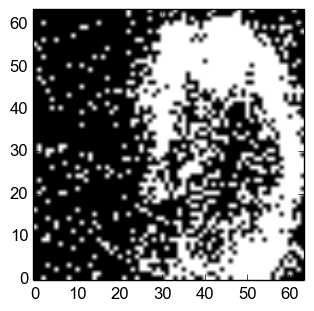

PyObject <matplotlib.image.AxesImage object at 0x7f45f1392f50>

In [15]:
figure(figsize=(3.5,3.5))
imagen=imshow(MascaraOtsu, cmap="gist_heat", origin="lower")

La máscara así obtenida tiene huecos y puntos sueltos. Para normalizarla un poco y tratar de que sea un objeto de un componente conexo, le aplicamos la función mostrada abajo. Esta función quita los canales que se encuentren sin vecinos y añade aquellos que se encuentren rodeados por al menos otros dos puntos.

In [16]:
function ParchaMascara01(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    (alto,ancho)=size(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    
    colchonvertical=zeros(1,ancho)
    colchonhorizontal=zeros(alto+2)
    
    temp=vcat(colchonvertical, temp, colchonvertical)
    temp=hcat(colchonhorizontal, temp, colchonhorizontal)
    
    
    for j=2:alto+1, k=2:ancho+1
        aux=temp[j-1:j+1,k-1:k+1]
        test=sum(aux)
        if(temp[j,k]<2.0 && test<2.1)
            result[j-1,k-1]=0
        #    println(j,k)
        elseif(temp[j,k]<1.1 && test>2.0)
            result[j-1,k-1]=1
        else
            result[j-1,k-1]=temp[j,k]
        end
    end   

    return result
    
end


ParchaMascara01 (generic function with 1 method)

In [17]:
for t=1:6
    MascaraOtsu=ParchaMascara01(MascaraOtsu); 
end
#pasala varias veces, hasta tener un solo componente conexo (cinco veces)
;

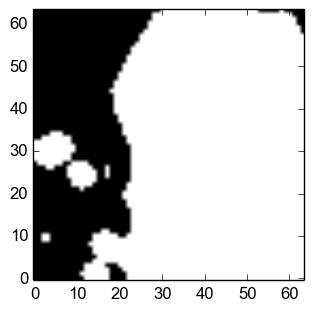

PyObject <matplotlib.image.AxesImage object at 0x7f45f134ad90>

In [18]:
figure(figsize=(3.5,3.5))
PyPlot.ion()
imagen=imshow(MascaraOtsu, cmap="gist_heat", origin="lower")

#origin lower sigue la convención gnuplot. Origen abajo izquierda. 
#La otra sigue la convención matrix (default).

Creo que está bien. Tal vez podríamos quitar los componentes fuera del cuerpo principal más tarde. Por el momento, quitemos los canales saturados promediandolos con sus vecinos.

In [19]:
extrema(Datos)

(-856.01806640625,4125.0)

In [20]:
function QuitaSaturados(data)
    tolerancia=1400
    tamanodatos=size(data)
    temp=copy(data)
    aux1=zeros(1,tamanodatos[1])
    aux2=zeros(tamanodatos[2]+2,1)
    temp=vcat(aux1,temp, aux1)
    temp=hcat(aux2, temp, aux2)
    result=zeros(data)
    for j=2:tamanodatos[1]+1, k=2:tamanodatos[2]+1
        if abs(temp[j,k])>tolerancia
            aux=temp[j-1,k-1]+temp[j-1,k]+temp[j-1,k+1]+
            temp[j,k-1]+temp[j,k+1]+
            temp[j+1,k-1]+temp[j+1,k]+temp[j+1,k+1]
            aux=aux/8
            result[j-1,k-1]=aux
        else
            result[j-1,k-1]=temp[j,k]
        end
    end
    return result
end
            

QuitaSaturados (generic function with 1 method)

In [21]:
function GaussSuavizar(data,Sigma)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3 sigmas.
    #Bien, veamos como chingaos le ponemos "padding" a las convoluciones.
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(data)
    datoscolchon=vcat(colchon*data[1], data, colchon*data[end])
    kernel=map(x->UnNormGauss(x,Sigma), [-medioancho:medioancho])
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(data)-medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(data))
    b=maximum(abs(result))
    result=result*a/b
    return result
end


GaussSuavizar (generic function with 1 method)

In [22]:
DatosDesaturados=zeros(Datos)
for t=1:tmax
    DatosDesaturados[:,:,t]=QuitaSaturados(Datos[:,:,t])
end

In [23]:
findmax(DatosDesaturados)

(624.3896484375,10782905)

Aplicar el Laplaciano sobre datos duros resulta muy poco conveniente, ya que es demasiado sensible a lo "no diferenciable" de la señal. Se recomienda pasar un filtro gaussiano primero. Primero pasamos uno temporal. Después definimos un filtro gaussiano
espacial que usa un kernel relativamente pequeño, con un decaimiento rápido.  Esto evita mezclar datos demasiado lejanos con el punto de interés.

In [24]:
DatosSuavesTiempo=zeros(DatosDesaturados)
for j=1:64, k=1:64
    porromponpon=reshape(DatosDesaturados[j,k,:],tmax)
    DatosSuavesTiempo[j,k,:]=GaussSuavizar(porromponpon, 3)
end

In [25]:
GaussianKernel=readdlm("GaussianMatrix.dat");
function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,end])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #piensa como normalizar
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end

GaussianSmooth (generic function with 1 method)

In [26]:
DatosSuaves=zeros(DatosSuavesTiempo)
for t=1:tmax
    DatosSuaves[:,:,t]=GaussianSmooth(DatosSuavesTiempo[:,:,t])
end

In [27]:
extrema(DatosSuaves)

(-534.0691753428515,534.4805064123128)

In [27]:
dedonde, adonde=500,2300  #Platica Heidelberg

(500,2300)

In [30]:
# a escribir, pa variar
for t=dedonde:adonde
#    aux=map(x-> isnan(x)?0:x, Chumbaganga[:,:,t])
    zacatlan="./GarbageCollector/LFPSuave-$t.dat"
    writedlm(zacatlan, DatosSuaves[:,:,t])
end

In [28]:
writedlm("Ejemplo45-57.dat",reshape(DatosSuaves[45,57,dedonde:adonde],adonde-dedonde+1))

Esta es la versión discreta del Laplaciano, usado primordialmente para "detección de bordes" por su alta sensibilidad a derivadas abruptas, que son justo nuestro caso.

In [28]:
LaplacianKernel=zeros(3,3);
#checa que Julia va ordenando los datos renglon por renglon, no columna por columna
LaplacianKernel=[[0.5 1. 0.5], [1. -6. 1], [0.5 1. 0.5]];

function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo+1, k=2:ancho+1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    return result
end

DiscreteLaplacian (generic function with 1 method)

Aplicamos ahora el Laplaciano a los datos por cuadro. Le llamaremos al resultado CSD, para recordar que lo que nos interesa es la *"densidad de fuentes de corriente"*.

In [29]:
CSD=zeros(formaarray)
for t=1:tmax
    CSD[:,:,t]=-DiscreteLaplacian(DatosSuaves[:,:,t])
end

In [30]:
#Quita la basura numerica porfa. Esto producira componentes MAS disjuntos.
map!(x->abs(x)<0.01? 0:x, CSD); 

Por supuesto, la CSD es el *negativo* del Laplaciano del LFP, esto es:
$\rho \propto -\nabla^2 V$

Hagamos un par de comparaciones. Como se ven ANTES y DESPUES del filtro Laplaciano.

In [31]:
CSD[:,:,700];

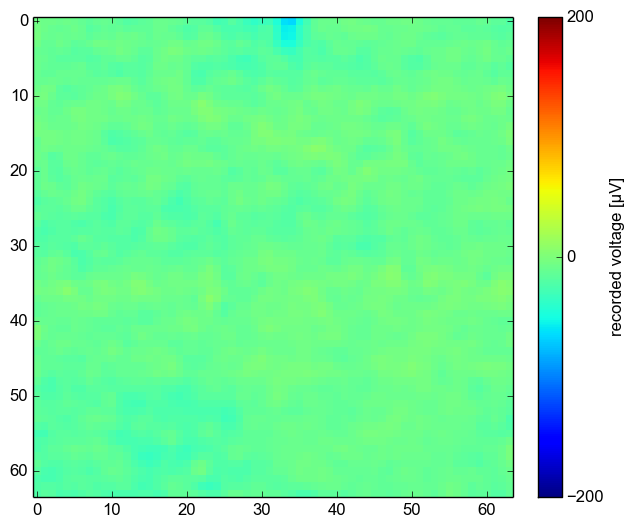

false

In [32]:
#guacala de jet. pero les gusta a los Journ. de Neurosc.
a=700
b=round(a/7022, 4)
figure()
imagen=imshow(DatosSuaves[:,:,a], origin="upper", vmin=-200, vmax=200, interpolation="none")
cb=colorbar(imagen, ticks=[-200, 0, +200],fraction=0.046, pad=0.04 )
cb[:set_label]("recorded voltage [µV]  ")
#savefig("LCF01-700.png", dpi=72)
PyPlot.close_queued_figs()

In [33]:
size(CSD)

(64,64,7601)

In [57]:
for t=dedonde:adonde
    gc()
    PyPlot.ioff()
    figure()
    b=round(t/7022, 4)
    imagen=imshow(DatosSuaves[:,:,t], cmap="jet", origin="upper", vmin=-200, vmax=200, 
    interpolation="none")
    cb=colorbar(imagen, ticks=[-200, 0, +200],fraction=0.046, pad=0.04 )
    cb[:set_label]("recorded voltage [µV]  ")
    cuac=savefig("GarbageCollector/LFP_cb-$t.png", dpi=72)
end

LoadError: interrupt
while loading In[57], in expression starting on line 1

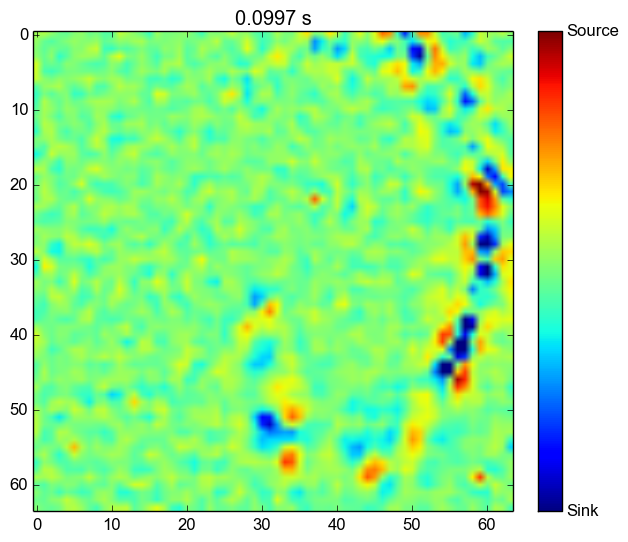

In [34]:
PyPlot.ion()
#figure(figsize=(3.5,3.5))
figure()
a=700
b=round(a/7022,4)
titulo="$b s"
#imagen=imshow(DatosLimpios[:,:,1999], cmap="gist_heat", origin="lower")
otraimagen=imshow(CSD[:,:,700], cmap="jet", origin="upper", vmin=-150, vmax=150)
#cb=colorbar(otraimagen)
cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04 )
cb[:set_ticklabels]([{"Sink"}, {"Source"}])
title(titulo)
savefig("CSDEjempl-700.png",dpi=72)
PyPlot.close()

In [35]:
PyPlot.close_queued_figs()

In [17]:
PyPlot.ioff()
@time for t=dedonde+11:adonde
    gc()
    figure()
    tiempo=round(t/7022,4)
    titulo="$tiempo s"
    putin=imshow(CSD[:,:,t], cmap="jet", origin="upper", vmin=-150, vmax=150)
    cb=colorbar(putin, ticks=[-150, +150],fraction=0.046, pad=0.04 )
    cb[:set_ticklabels]([{"Sink", fontsize=22}, {"Source"}])
    title(titulo)
    savefig("CSD-$t.png", dpi=72)
    #gc()
    PyPlot.close_queued_figs() #this sseem to make an amount of HUGE time diference
end


LoadError: dedonde not defined
while loading In[17], in expression starting on line 2

Bien, la aplicación de los dos filtros genera un poco de colas numéricas pequeñas que sólo estorban en memoria. Las suprimimos con el siguiente umbral.

In [34]:
for t=1:tmax
#    aux=map(x-> isnan(x)?0:x, Chumbaganga[:,:,t])
    zacatlan="GarbageCollector/CSD-$t.dat"
    writedlm(zacatlan, CSD[:,:,t])
end


Para obtener la conexión de los componentes, necesitamos considerar la 8-vecindad de cada punto.

In [35]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end

vecindad8 (generic function with 1 method)

In [ ]:
@time for t=1:tmax
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
    SpikeCountPositivo=zeros(64,64)
    SpikeCountNegativo=zeros(64,64)
    #Solo aquellos que se encuentren en la Mascara de Otsu
    for j=1:64, k=1:64
        if(CSD[j,k,t]<-0.0) && MascaraOtsu[j,k]>0.5     
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
        elseif(CSD[j,k,t]>0.0) && MascaraOtsu[j,k]>0.5
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    listaneg=copy(ActividadNegativa)
    listapos=copy(ActividadPositiva)
    componentesneg=Set{Any}()
    componentespos=Set{Any}()
    #Primero lo negativo (pozos)
    while(length(listaneg)!=0)
        x=pop!(listaneg) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listaneg)
             #   
                    deleteat!(listaneg, indexin({v}, listaneg))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentesneg, componentecurlab)
    end


    centrosdemasaneg=[[0 0 0];]
    for p in componentesneg
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
            masalocal=CSD[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasaneg=vcat(centrosdemasaneg, A)
    end
    centrosdemasaneg=centrosdemasaneg[2:end,:]
    zacatlan="GarbageCollector/CMNegLapla-$t.dat"
    writedlm(zacatlan, centrosdemasaneg)
    ##### Ahora lo posittivo (fuentes)
    while(length(listapos)!=0)
        x=pop!(listapos) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listapos)
             #   
                    deleteat!(listapos, indexin({v}, listapos))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentespos, componentecurlab)
    end


    centrosdemasapos=[[0 0 0];]
    for p in componentespos
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
            masalocal=CSD[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasapos=vcat(centrosdemasapos, A)
    end
    centrosdemasapos=centrosdemasapos[2:end,:]
    zacatlan="GarbageCollector/CMPosLapla-$t.dat"
    writedlm(zacatlan, centrosdemasapos)
end

In [121]:
dedonde, adonde

(250,2300)